In [1]:
import nbimporter
import numpy as np
import pandas as pd
import os
import ast
from OOP_financial_dataset import Financial_data_analysis
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

In [28]:
class Sentiment_Relevancy_analysis:
    def __init__(self, path, ticker_set):
        self.data_path = path
        self.ticker_set = ticker_set
        self.financial_object = Financial_data_analysis('NVDA')
        self.date_list = self.financial_object.date_list
    
    def read_data(self):
        file_path = self.data_path
        print(f"Attempting to read: {file_path} with separator=';'")
        df_features = pd.read_csv( file_path, sep=';', engine='python', quotechar='"', on_bad_lines='skip' )
        print("\nSuccessfully loaded features.csv!")
        return df_features

    def extract_tickers(self,ticker_str):
        parsed_literal = ast.literal_eval(ticker_str)
        if isinstance(parsed_literal, list):
            # If it's a list, extract non-empty strings and convert to upper
            tickers = [str(item).strip().upper() for item in parsed_literal if isinstance(item, str) and str(item).strip()]
            return tickers
        else:
            # If parsing didn't result in a list, return empty
            return []
    
    def filter_date_ticker(self):
        df_features = self.read_data()
        df_features['posted_at_dt'] = pd.to_datetime(df_features['posted_at'], errors='coerce')
        df_features['timestamp'] = pd.to_datetime(df_features['timestamp'])

        dates_to_keep = pd.to_datetime(self.date_list).date
        
        # Pick out the dates column
        posted_dates = df_features['posted_at_dt'].dt.date
        
        # Define the mask to check for the dates to keep
        keep_mask = posted_dates.isin(dates_to_keep)
        
        # Apply the mask over whole dataframe
        df_filtered_by_date = df_features[keep_mask].copy()

        df_filtered_by_date['extracted_tickers'] = df_filtered_by_date['ticker'].apply(self.extract_tickers)

        is_ticker_related = df_filtered_by_date['extracted_tickers'].apply(lambda tickers_list: any(ticker in self.ticker_set for ticker in tickers_list))
        
        df_date_ticker = df_filtered_by_date[is_ticker_related].copy()

        print(f"\nShape after filtering for automobile tickers: {df_date_ticker.shape}")

        return df_date_ticker

    def run_for_sentiments(self): 
        df_date_ticker = self.filter_date_ticker()
        
        sentiment_col_pos = 'normal_sentiment_score_positive'
        sentiment_col_neg = 'normal_sentiment_score_negative'
        count_col = 'normal_sentiment_weighted'
        
        required_cols = [sentiment_col_pos, sentiment_col_neg, count_col, 'posted_at_dt']
        
        daily_normalized_sentiment = df_date_ticker.groupby(df_date_ticker['posted_at_dt'].dt.date).agg(
          mean_pos_score=(sentiment_col_pos, 'mean'),
          mean_neg_score=(sentiment_col_neg, 'mean'),
          post_count=(count_col, 'count'))
        
        # Calculate the difference score
        daily_normalized_sentiment['norm_sentiment'] = daily_normalized_sentiment['mean_pos_score'] - daily_normalized_sentiment['mean_neg_score']
        
        daily_normalized_sentiment.reset_index(inplace=True)
        daily_normalized_sentiment.rename(columns={'posted_at_dt': 'date'}, inplace=True)

        norm_sentiment = np.array(daily_normalized_sentiment['norm_sentiment'])

        return norm_sentiment, daily_normalized_sentiment

    def run_for_relevancy(self):
        df_date_ticker = self.filter_date_ticker()

        relevancy_scores = []
        
        for tickers_list in df_date_ticker['extracted_tickers']:
            score_for_this_row = 0
            
            for ticker in tickers_list:
                if ticker in tech_tickers_set:
                    score_for_this_row += 1
            relevancy_scores.append(score_for_this_row)
        
        df_date_ticker['relevancy_column'] = relevancy_scores
        
        daily_aggregated_relevancy = df_date_ticker.groupby(df_date_ticker['posted_at_dt'].dt.date)['relevancy_column'].agg(
            rel_posts_per_day = 'count',
            rel_tickers_per_day = 'sum',
            mean_relevancy = 'mean')
        
        daily_aggregated_relevancy.reset_index(inplace=True)
        daily_aggregated_relevancy.rename(columns={'posted_at_dt': 'date'}, inplace=True)

        mean_relevancy = np.array(daily_aggregated_relevancy['mean_relevancy'])
        
        return mean_relevancy, daily_aggregated_relevancy

    def save_the_csv(self):
        mean_relevancy, daily_aggregated_relevancy = self.run_for_relevancy()
        norm_sentiment, daily_normalized_sentiment = self.run_for_sentiments()
        df = pd.DataFrame({
            'Sentiment Score': norm_sentiment,
            'Relevancy Score': mean_relevancy
        })
        filename = 'sentiment_relevancy_score.csv'
        df.to_csv(filename, index=False)
    
    def plot_relevancy_trend(self):
        mean_relevancy, daily_aggregated_relevancy = self.run_for_relevancy()
        daily_aggregated_relevancy.plot(x='date', y='mean_relevancy', figsize=(10, 6), linewidth=3, color = '#4285f4')
        plt.ylabel('Relevancy Score', fontsize = 26)
        plt.yticks(fontsize=22)
        plt.xlabel('Date', fontsize=26)
        plt.xticks(fontsize = 20, rotation = 45)
        legend = plt.legend(fontsize=23)
        legend.get_frame().set_alpha(0)
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_linewidth(2)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("industry_relevancy_trend.jpg", dpi=1000)
        plt.show()

    def plot_sentiment_trend(self):
        norm_sentiment, daily_normalized_sentiment = self.run_for_sentiments()
        daily_normalized_sentiment.plot(x='date', y='norm_sentiment', figsize=(10, 6), linewidth=3, color = '#4285f4')
        plt.ylabel('Sentiment Score', fontsize = 26)
        plt.yticks(fontsize=22)
        plt.xlabel('Date', fontsize=26)
        plt.xticks(fontsize = 20, rotation = 45)
        legend = plt.legend(fontsize=23)
        legend.get_frame().set_alpha(0)
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_linewidth(2)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("industry_sentiment_trend.jpg", dpi=1000)
        plt.show()

In [29]:
path = './data/features.csv'
tech_tickers_set = {'AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'META', 'NVDA',
    'AMD', 'INTC', 'QCOM', 'TSM', 'AVGO', 'TXN', 'MU', 'ASML',
    'LRCX', 'AMAT', 'NXPI', 'ON', 'ADI', 'MRVL', 'KLAC', 'TER', 'GFS', 'UMC',
    'CRM', 'ADBE', 'ORCL', 'SAP', 'NOW', 'INTU', 'IBM', 'SNOW', 'U', 'ZM',
    'DOCU', 'PANW', 'FTNT', 'CRWD', 'TEAM', 'WDAY', 'SHOP', 'SPOT', 'PLTR',
    'NET', 'ZS', 'HUBS', 'VEEV', 'MDB', 'PTC', 'DDOG', 'ANSS','DELL', 'HPQ', 'SONY', 'LOGI', 'CSCO', 'ANET', 'GLW',
    'PINS', 'SNAP', 'EBAY','TWTR', 'NTDOY', 'NTDOF', '7974.T','EA', 'TTWO','ATVI', 'ACN', 'INFY', 'CTSH'}

model = Sentiment_Relevancy_analysis(path, tech_tickers_set)

[*********************100%***********************]  1 of 1 completed


In [31]:
model.save_the_csv()

Attempting to read: ./data/features.csv with separator=';'

Successfully loaded features.csv!

Shape after filtering for automobile tickers: (2514, 24)
Attempting to read: ./data/features.csv with separator=';'

Successfully loaded features.csv!

Shape after filtering for automobile tickers: (2514, 24)


In [25]:
# sentiment_score, df = model.run_for_sentiments()

In [26]:
# sentiment_score

In [27]:
# relevancy_score, df = model.run_for_relevancy()

In [13]:
# relevancy_score

Attempting to read: ./data/features.csv with separator=';'

Successfully loaded features.csv!

Shape after filtering for automobile tickers: (2514, 24)


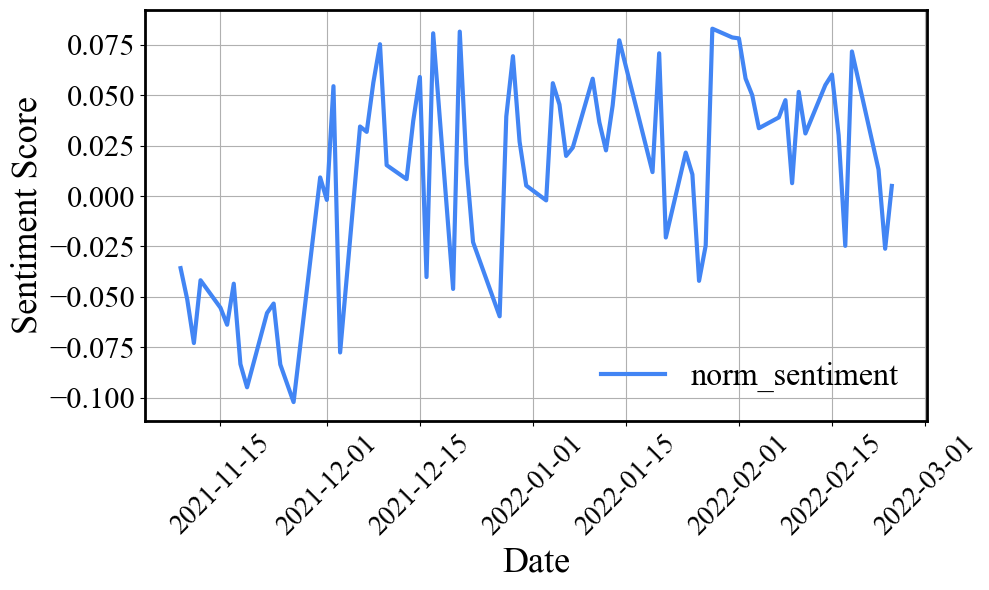

In [7]:
model.plot_sentiment_trend()

Attempting to read: ./data/features.csv with separator=';'

Successfully loaded features.csv!

Shape after filtering for automobile tickers: (2514, 24)


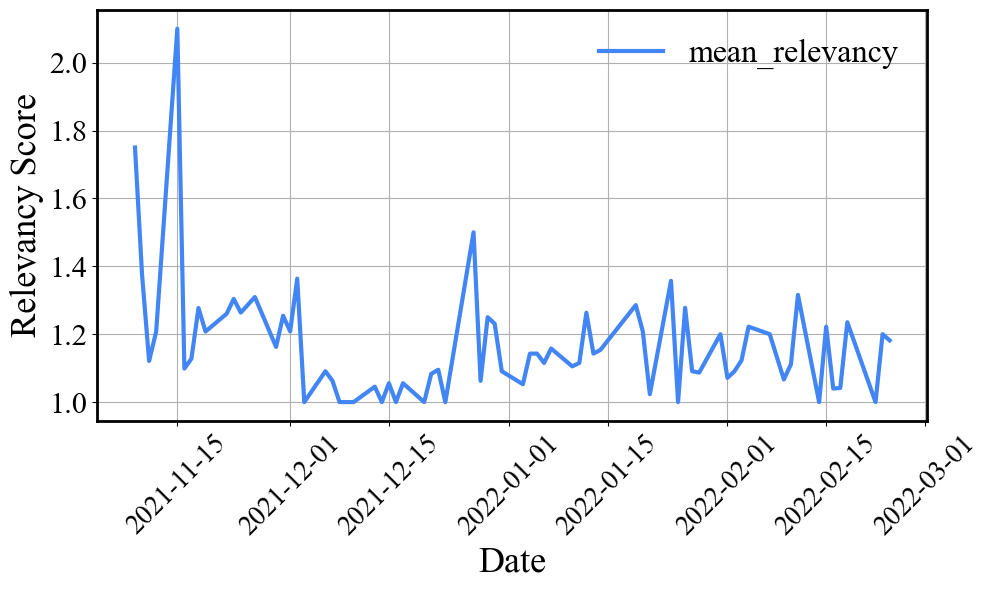

In [8]:
model.plot_relevancy_trend()